2024-07-12 16:35:11,558 |INFO     |beamngpy                      |Started BeamNGpy logging.
2024-07-12 16:35:13,610 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\site-packages\beamngpy\connection\connection.py:149: ResourceWarning: unclosed <socket.socket fd=1660, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('0.0.0.0', 58953)>
  sleep(5)

2024-07-12 16:35:13,610 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\site-packages\beamngpy\connection\connection.py:149: ResourceWarning: unclosed <socket.socket fd=1660, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('0.0.0.0', 58953)>
  sleep(5)

2024-07-12 16:35:13,614 |INFO     |beamngpy.BeamNGpy             |Opening BeamNGpy instance.
2024-07-12 16:35:13,618 |INFO     |beamngpy.BeamNGpy             |Started BeamNG.
2024-07-12 16:35:23,630 |INFO     |beamngpy.BeamNGpy             |Connecting to BeamNG.tech at: (localhos

in while...
No data received.
in while...
No data received.
in while...
No data received.
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
No data received.
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
No data received.
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
No data received.
in while...
got raw data...
got discretized data...
to plot...
to get vehicle state...
in while...
got raw data...
got discr

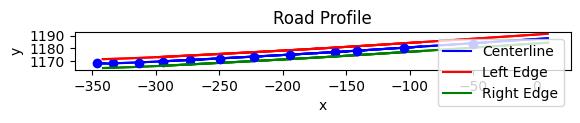

2024-07-12 16:36:28,607 |INFO     |beamngpy.BeamNGpy             |Closing BeamNGpy instance.
2024-07-12 16:36:28,610 |INFO     |beamngpy.Vehicle              |Disconnected from vehicle ego_vehicle and detached sensors.
2024-07-12 16:36:28,612 |INFO     |beamngpy.BeamNGpy             |Terminating BeamNG.tech process.


to close...


2024-07-12 16:36:28,828 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\subprocess.py:1052: ResourceWarning: subprocess 21332 is still running
  _warn("subprocess %s is still running" % self.pid,

2024-07-12 16:36:28,828 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\subprocess.py:1052: ResourceWarning: subprocess 21332 is still running
  _warn("subprocess %s is still running" % self.pid,

2024-07-12 16:36:28,833 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\site-packages\beamngpy\beamng\beamng.py:300: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  self.process = None

2024-07-12 16:36:28,833 |WARNING  |py.warnings                   |c:\Users\User\.conda\envs\BeamNG32\lib\site-packages\beamngpy\beamng\beamng.py:300: ResourceWarning: unclosed file <_io.BufferedWriter name=3>
  self.process = None



In [ ]:
from time import sleep
import matplotlib.pyplot as plt

from beamngpy import BeamNGpy, Scenario, Vehicle, set_up_simple_logging, angle_to_quat
from beamngpy.sensors import RoadsSensor
from beamngpy.misc.vec3 import vec3

from matplotlib.animation import FuncAnimation

import numpy as np

GRANULARITY = 100


# Evaluates the road parametric cubic polynomials.
def discretize(d):
    eval_range = GRANULARITY + 1
    granularity_inv = 1.0 / GRANULARITY
    # Cache the individual coefficients of the u(p), v(p) equations, for the road centerline, the road left edge, and the road right edge.
    aU_CL, bU_CL, cU_CL, dU_CL = d["uAofCL"], d["uBofCL"], d["uCofCL"], d["uDofCL"]
    aV_CL, bV_CL, cV_CL, dV_CL = d["vAofCL"], d["vBofCL"], d["vCofCL"], d["vDofCL"]
    aU_LE, bU_LE, cU_LE, dU_LE = (
        d["uAofLeftRE"],
        d["uBofLeftRE"],
        d["uCofLeftRE"],
        d["uDofLeftRE"],
    )
    aV_LE, bV_LE, cV_LE, dV_LE = (
        d["vAofLeftRE"],
        d["vBofLeftRE"],
        d["vCofLeftRE"],
        d["vDofLeftRE"],
    )
    aU_RE, bU_RE, cU_RE, dU_RE = (
        d["uAofRightRE"],
        d["uBofRightRE"],
        d["uCofRightRE"],
        d["uDofRightRE"],
    )
    aV_RE, bV_RE, cV_RE, dV_RE = (
        d["vAofRightRE"],
        d["vBofRightRE"],
        d["vCofRightRE"],
        d["vDofRightRE"],
    )

    # Will evaluate each parametric cubic, discretized at the chosen granularity.
    pts_CL, pts_LE, pts_RE = [], [], []
    for i in range(eval_range):
        p = i * granularity_inv  # The parameter p, in [0, 1], and its powers.
        p2 = p * p
        p3 = p2 * p

        # Evaluate the polynomials.
        u_CL = (
            aU_CL + (p * bU_CL) + (p2 * cU_CL) + (p3 * dU_CL)
        )  # Road centerline u(p), v(p).
        v_CL = aV_CL + (p * bV_CL) + (p2 * cV_CL) + (p3 * dV_CL)
        u_LE = (
            aU_LE + (p * bU_LE) + (p2 * cU_LE) + (p3 * dU_LE)
        )  # Road left edge u(p), v(p).
        v_LE = aV_LE + (p * bV_LE) + (p2 * cV_LE) + (p3 * dV_LE)
        u_RE = (
            aU_RE + (p * bU_RE) + (p2 * cU_RE) + (p3 * dU_RE)
        )  # Road right edge u(p), v(p).
        v_RE = aV_RE + (p * bV_RE) + (p2 * cV_RE) + (p3 * dV_RE)

        pts_CL.append(
            vec3(u_CL, v_CL) + vec3(d["xStartCL"], d["yStartCL"])
        )  # Road centerline.
        pts_LE.append(
            vec3(u_LE, v_LE) + vec3(d["xStartL"], d["yStartL"])
        )  # Road left edge (with offset added horizontally).
        pts_RE.append(
            vec3(u_RE, v_RE) + vec3(d["xStartR"], d["yStartR"])
        )  # Road right edge (with offset added horizontally).

    return pts_CL, pts_LE, pts_RE


def update():
    sleep(1)
    print("in while...")
    d_raw = rs.poll()
    if not d_raw:
        print("No data received.")
        return
    d = d_raw[0]
    print("got raw data...")
    pts_CL, pts_LE, pts_RE = discretize(d)
    print("got discretized data...")
    ax.set(xlabel="x", ylabel="y", title="Road Profile")
    ax.set_aspect("equal", adjustable="box")
    print("to plot...")
    x, y = [], []  # Plot the road centerline.
    for i in range(len(pts_CL)):
        p = pts_CL[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "b")
    x, y = [], []  # Plot the road left edge.
    for i in range(len(pts_LE)):
        p = pts_LE[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "r")
    x, y = [], []  # Plot the road right edge.
    for i in range(len(pts_RE)):
        p = pts_RE[i]
        x.append(p.x)
        y.append(p.y)
    ax.plot(x, y, "g")
    plt.legend(["Centerline", "Left Edge", "Right Edge"])
    print("to get vehicle state...")
    vehicle.sensors.poll()  # Plot vehicle position and direction.
    pos = vehicle.state["pos"]
    dir = vehicle.state["dir"]
    vp = vec3(pos[0], pos[1])
    v1 = vp + vec3.normalize(vec3(dir[0], dir[1])) * 10.0
    v2 = v1 - vp
    ax.plot(vp.x, vp.y, "bo")
    plt.arrow(vp.x, vp.y, v2.x, v2.y, width=0.05)

    frames.append([ax.plot])


if __name__ == "__main__":
    set_up_simple_logging()

    # Start up the simulator.
    bng = BeamNGpy("localhost", 25252)
    bng.open(launch=True)
    scenario = Scenario(
        "italy",
        "roads_sensor_demo",
        description="Spanning the map with the roads sensor",
    )
    vehicle = Vehicle("ego_vehicle", model="etk800", license="RED", color="Red")
    scenario.add_vehicle(
        vehicle,
        pos=(-361.76326635601, 1169.0963008935, 168.6981158547),
        rot_quat=angle_to_quat((0, 0, 270)),
    )
    scenario.make(bng)
    bng.settings.set_deterministic(60)  # Set simulator to 60hz temporal resolution
    bng.scenario.load(scenario)
    bng.ui.hide_hud()
    bng.scenario.start()

    rs = RoadsSensor("rs1", bng, vehicle, physics_update_time=1.0)

    print("Collecting roads readings...")
    vehicle.ai.set_mode("traffic")
    sleep(3.0)
    fig, ax = plt.subplots()
    frames = []

    # Create the animation frames
    for k in range(20):
        update()

    # Create the animation
    animation = FuncAnimation(fig, update, frames, interval=50)
    plt.show()

    # Close the simulation.
    print("to disconnect...")
    bng.disconnect()